In [125]:
import pandas as pd
import numpy as np
import math

In [126]:
class Record:
    def __init__(self):
        self.balance_usdt = 0.0
        self.balance_asset = 0.0
        self.sold_asset = 0.0
        self.bought_asset = 0.0
        self.sold_usdt = 0.0
        self.bought_usdt = 0.0
        self.fees_asset = 0.0
        self.fees_usdt = 0.0
        self.range_lower = 0.0
        self.range_upper = 0.0

In [127]:
from abc import ABC, abstractmethod

class UniswapV3SingleSidedRange(ABC):
    def __init__(self, fee_tier):
        self.fee_tier = fee_tier
        self.balance_usdt = 0.0
        self.balance_asset = 0.0
        self.sold_asset = 0.0
        self.bought_asset = 0.0
        self.sold_usdt = 0.0
        self.bought_usdt = 0.0
        self.fees_asset = 0.0
        self.fees_usdt = 0.0
        self.liquidity = 0.0
        self.range_lower = 0.0
        self.range_upper = 0.0
        self.last_spot_price = 0.0

    def settle(self, record):
        record.balance_usdt = self.balance_usdt
        record.balance_asset = self.balance_asset
        record.sold_asset = self.sold_asset
        record.bought_asset = self.bought_asset
        record.sold_usdt = self.sold_usdt
        record.bought_usdt = self.bought_usdt
        record.fees_asset = self.fees_asset
        record.fees_usdt = self.fees_usdt
        record.range_lower = self.range_lower
        record.range_upper = self.range_upper

        self.balance_asset += -self.sold_asset + self.bought_asset
        self.balance_usdt += -self.sold_usdt + self.bought_usdt
        self.sold_asset = 0.0
        self.bought_asset = 0.0
        self.sold_usdt = 0.0
        self.bought_usdt = 0.0
        

    def compute(self):
        self.compute_asset_liquidity()
        self.compute_usdt_liquidity()

    def compute_asset_liquidity(self):
        if self.balance_asset <= 0:
            return
        numerator = self.balance_asset * math.sqrt(self.range_lower) * math.sqrt(self.range_upper)
        denominator = math.sqrt(self.range_upper) - math.sqrt(self.range_lower)
        self.liquidity = numerator/denominator

    def compute_usdt_liquidity(self):
        if self.balance_usdt <= 0:
            return
        sqrt_pc = math.sqrt(self.range_upper)
        sqrt_pa = math.sqrt(self.range_lower)
        delta_price = sqrt_pc - sqrt_pa
        self.liquidity = self.balance_usdt / delta_price

    def swap(self, price):
        if price > self.range_lower and price < self.range_upper: #Within quote range
            if price >= self.last_spot_price: # price moving upwards which implies we are selling asset and buying USDT
                if self.balance_asset > 0: # did we accrue any? cause this is a USDT range
                    ref_price = min(price, self.range_upper)
                    self.sold_asset = self.asset_sold(ref_price, self.last_spot_price, self.liquidity) 
                    self.bought_usdt = self.usdt_bought(ref_price, self.last_spot_price, self.liquidity)
                    self.fees_asset = self.sold_asset * self.fee_tier
                else:
                    pass # No asset to sell
            else: # price moving downwards which implies that we are buying asset and selling USDT
                if self.balance_usdt > 0:
                    ref_price = max(price, self.range_lower)
                    self.bought_asset += self.asset_bought(ref_price, self.last_spot_price, self.liquidity)
                    self.sold_usdt = self.usdt_sold(ref_price, self.last_spot_price, self.liquidity)
                    self.fees_usdt = self.sold_usdt * self.fee_tier
                else:
                    pass # No USDT to sell
                    
            self.last_spot_price = price

    def asset_sold(self, current_price, lower, liquidity):
        numerator = math.sqrt(current_price) - math.sqrt(lower)
        denominator = math.sqrt(current_price)* math.sqrt(lower)
        sold_asset = numerator * liquidity / denominator 
        return sold_asset 

    def asset_bought(self, current_price, upper, liquidity):
        numerator = math.sqrt(upper) - math.sqrt(current_price)
        denominator = math.sqrt(current_price) * math.sqrt(upper)
        bought_asset = numerator * liquidity / denominator 
        return bought_asset 
        
    def usdt_sold(self, current_price, upper, liquidity):
        return (math.sqrt(upper) - math.sqrt(current_price)) * liquidity 

    def usdt_bought(self, current_price, lower, liquidity):
        return (math.sqrt(current_price) - math.sqrt(lower)) * liquidity


class UniswapV3RangeUSDT(UniswapV3SingleSidedRange):
    # This is a one sided quote
    def __init__(self, fee_tier, range_lower, range_upper, amount):
        super().__init__(fee_tier)
        self.balance_usdt = amount
        self.range_lower = range_lower
        self.range_upper = range_upper
        self.last_spot_price = range_upper
        self.compute()



class UniswapV3RangeAsset(UniswapV3SingleSidedRange):
    # This is a one sided quote
    def __init__(self, fee_tier, range_lower, range_upper, amount):
        super().__init__(fee_tier)
        self.balance_asset = amount
        self.range_lower = range_lower
        self.range_upper = range_upper
        self.last_spot_price = range_lower
        self.compute()
        
    
        
class UniswapV3Pool:
    def __init__(self, pool_fee_percent):
        # As per UniswapV3 settings, for USDT-asset pool, currency0 = USDT and currency1 = asset
        self.base_fee_percent = pool_fee_percent
        self.usdt_range = None
        self.asset_range = None
        
    def clear_quote_usdt(self):
        self.usdt_range = None

    def clear_quote_asset(self):
        self.asset_range = None
        
    def quote_usdt(self, amount, current_price, price_lower):
        self.usdt_range = UniswapV3RangeUSDT(self.base_fee_percent, price_lower, current_price, amount)

    def quote_asset(self, amount, current_price, price_upper):
        self.asset_range = UniswapV3RangeAsset(self.base_fee_percent, current_price, price_upper, amount)

    def swap(self, price, assetrecord, usdtrecord):
        if self.asset_range is not None:
            self.asset_range.swap(price)
            self.asset_range.settle(assetrecord)
        if self.usdt_range is not None:
            self.usdt_range.swap(price)
            self.usdt_range.settle(usdtrecord)

In [128]:
class Quoter:
    def __init__(self, pool, usdt_balance, asset_balance, asset_range, requote_start, usdt_range):
        self.pool = pool
        self.balance_usdt = usdt_balance
        self.balance_asset = asset_balance
        self.asset_range = asset_range
        self.usdt_range = usdt_range
        self.requote_start_pct = requote_start
        self.swap_price = None

    def swap(self, price, current_time, assetrecord, usdtrecord):
        if self.swap_price is None:
            self.quote_atm(price, current_time)
            return True
            
        self.pool.swap(price, assetrecord, usdtrecord)

        requote = False
        if price > self.swap_price * (1 + self.requote_start_pct) or price < self.swap_price * (1 - self.usdt_range) or price < self.swap_price * (1 - self.requote_start_pct):
            requote = True

        if requote:
            self.requote_atm(price, current_time)
            self.swap_priced = price
        return requote
        
    def quote_atm(self, current_price, current_time):
        self.pool.quote_asset(self.balance_asset, current_price, current_price * (1.0 + self.asset_range))
        self.swap_price = current_price
        
    def requote_atm(self, current_price, current_time):
        self.balance_usdt = 0 if pool.usdt_range is None else pool.usdt_range.balance_usdt + pool.usdt_range.fees_usdt
        self.balance_asset = 0 if pool.usdt_range is None else pool.usdt_range.balance_asset + pool.usdt_range.fees_asset
        self.balance_usdt += 0 if pool.asset_range is None else pool.asset_range.balance_usdt + pool.asset_range.fees_usdt
        self.balance_asset += 0 if pool.asset_range is None else pool.asset_range.balance_asset + pool.asset_range.fees_asset

        if pool.usdt_range is not None:
            pool.usdt_range.fees_usdt = 0
            pool.usdt_range.fees_asset = 0

        if pool.asset_range is not None:
            pool.asset_range.fees_usdt = 0
            pool.asset_range.fees_asset = 0
            
        if self.balance_usdt > 0:
            pool.quote_usdt(self.balance_usdt, current_price, current_price * (1 - self.usdt_range))
        if self.balance_asset > 0:
            pool.quote_asset(self.balance_asset, current_price, current_price * (1 + self.asset_range))

In [129]:
from tqdm import tqdm

class RequoteStrategy:
    def __init__(self, quoter):
        self.quoter = quoter
        self.results = pd.DataFrame()
    
    def run(self, swap_df):
        requote = True
        count = 0
        for index, row in tqdm(swap_df.iterrows()):
            assetrecord = Record()
            usdtrecord = Record()
            requote = self.quoter.swap(row['price'], index, assetrecord, usdtrecord)
            self.results.loc[index, "requote"] = 1.0 if requote else 0.0
            self.results.loc[index, "leg_0_asset_notional"] = usdtrecord.balance_asset
            self.results.loc[index, "leg_0_usdt_notional"] = usdtrecord.balance_usdt
            self.results.loc[index, "leg_0_fees_asset"] = usdtrecord.fees_asset
            self.results.loc[index, "leg_0_fees_usdt"] = usdtrecord.fees_usdt
            self.results.loc[index, "leg_0_lower"] = usdtrecord.range_lower
            self.results.loc[index, "leg_0_upper"] = usdtrecord.range_upper
            self.results.loc[index, "leg_0_bought_asset"] = usdtrecord.bought_asset
            self.results.loc[index, "leg_0_sold_asset"] = usdtrecord.sold_asset
            self.results.loc[index, "leg_0_bought_usdt"] = usdtrecord.bought_usdt
            self.results.loc[index, "leg_0_sold_usdt"] = usdtrecord.sold_usdt
            
            self.results.loc[index, "leg_1_asset_notional"] = assetrecord.balance_asset
            self.results.loc[index, "leg_1_usdt_notional"] = assetrecord.balance_usdt
            self.results.loc[index, "leg_1_fees_asset"] = assetrecord.fees_asset
            self.results.loc[index, "leg_1_fees_usdt"] = assetrecord.fees_usdt
            self.results.loc[index, "leg_1_lower"] = assetrecord.range_lower
            self.results.loc[index, "leg_1_upper"] = assetrecord.range_upper
            self.results.loc[index, "leg_1_bought_asset"] = assetrecord.bought_asset
            self.results.loc[index, "leg_1_sold_asset"] = assetrecord.sold_asset
            self.results.loc[index, "leg_1_bought_usdt"] = assetrecord.bought_usdt
            self.results.loc[index, "leg_1_sold_usdt"] = assetrecord.sold_usdt
            self.results.loc[index, "current_price"] = row["price"]

In [136]:
import pandas as pd

swap_df = pd.read_csv("btc.csv", header=0, index_col='Timestamp', parse_dates=['Timestamp']).iloc[:, -1:]
swap_df.columns = ['price']
print(swap_df.head(2))
print(swap_df.shape)

                        price
Timestamp                    
2025-04-24 00:00:00  93690.64
2025-04-24 00:01:00  93720.79
(43201, 1)


In [142]:
pool = UniswapV3Pool(0.0005) # pool fee at 5 bps
quoter = Quoter(pool=pool, usdt_balance=0, asset_balance=1, asset_range=0.05, requote_start=0.01, usdt_range=0.01)
dumb_algo = RequoteStrategy(quoter) # requote dynamically
dumb_algo.run(swap_df)

43201it [02:11, 329.71it/s]


In [143]:
dumb_algo.results.to_csv("results.csv")
pnl_df = pd.DataFrame(index = dumb_algo.results.index)

In [144]:
pnl_df['asset_balance'] = dumb_algo.results["leg_1_asset_notional"] + dumb_algo.results["leg_0_asset_notional"]
pnl_df['asset_balance'] += dumb_algo.results["leg_1_fees_asset"].cumsum() + dumb_algo.results['leg_0_fees_asset'].cumsum()
pnl_df['usdt_balance'] = dumb_algo.results["leg_1_usdt_notional"] + dumb_algo.results["leg_0_usdt_notional"]
pnl_df['usdt_balance'] += dumb_algo.results["leg_1_fees_usdt"].cumsum() + dumb_algo.results['leg_0_fees_usdt'].cumsum()
pnl_df['net_pos'] = pnl_df['asset_balance'] + pnl_df['usdt_balance'] / dumb_algo.results['current_price']

<Axes: >

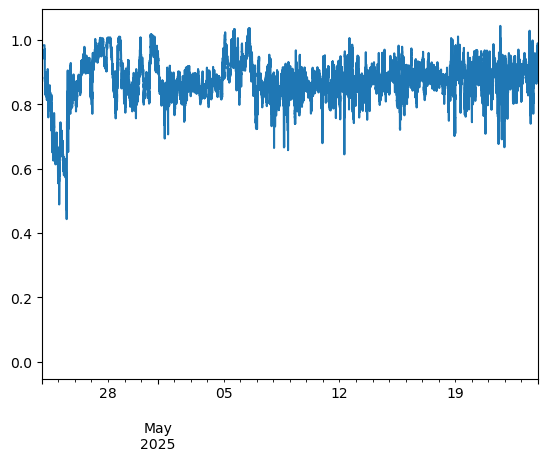

In [145]:
change = pnl_df['asset_balance'].dropna().pct_change()
change.replace([np.inf, -np.inf], np.nan, inplace=True)
pnl_df['asset_balance'].dropna().plot()

<Axes: >

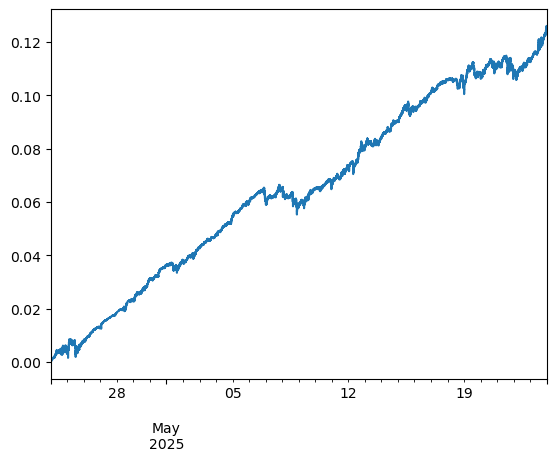

In [148]:
pnl = pnl_df['net_pos'].pct_change().dropna()
pnl.replace([np.inf, -np.inf], np.nan, inplace=True)
pnl.dropna().cumsum().plot()

<Axes: >

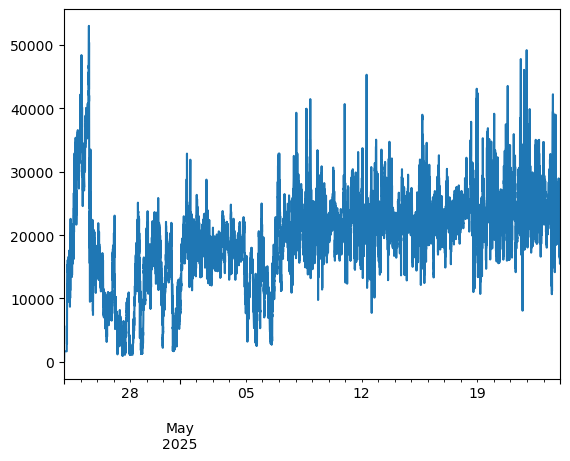

In [147]:
pnl_df['usdt_balance'].dropna().plot()